
# 🐾 Data for the Wild: Understanding Endangered Animals
**Duration:** 20–30 minutes  
**Tools:** Python, pandas, matplotlib  
**Dataset:** Animal Information Dataset (CSV)

**Big Question:** _What can data teach us about endangered animals—and how can we use it to care better?_

Today you'll use real animal data to:
- Clean and standardize messy values (like `"270-310"`).
- Ask and answer questions about **Conservation Status** (e.g., Endangered, Vulnerable).
- Pick **one endangered animal** and compare it with similar species to discover a trend.



## 🎯 Learning Goals
By the end of this activity, you will be able to:
1. Load a CSV into pandas and **inspect** columns and rows.  
2. **Pre-clean** data by converting ranges to numbers and standardizing categories.  
3. Create **subsets** (e.g., all Endangered animals, or all animals in a Family/Habitat).  
4. Use **groupby** + **visualization** to compare your chosen animal to similar species.  
5. **Explain** your findings in clear, simple language.


## 1) Setup & Imports (run this first)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline
pd.set_option("display.max_columns", 50)



## 2) Load the Dataset
> If your CSV has a different name or is in another folder, change `DATA_PATH` below.

## 2) Load the Dataset
Let's read the CSV file into a pandas DataFrame and peek at the first few rows.

To do this you'll need to add the data to your collab using the following steps
1. Click the file folder on the right side panel
2. rightclick the white space to create a new folder
3. rename the new folder `data`
4. download [this linked file](https://drive.google.com/file/d/1hrI2QJxpZHv9drTkI6QdKBQ1D0arp-Q-/view?usp=drive_link) from google drive
5. click the upload button place this file in your data folder



In [2]:

DATA_PATH = "data/Animal-dataset.csv"

animals = pd.read_csv(DATA_PATH)

animals.head()


,Animal,Height (cm),Weight (kg),Color,Lifespan (years),Diet,Habitat,Predators,Average Speed (km/h),Countries Found,Conservation Status,Family,Gestation Period (days),Top Speed (km/h),Social Structure,Offspring per Birth
0,Aardvark,105-130,40-65,Grey,20-30,Insectivore,"Savannas, Grasslands","Lions, Hyenas",40,Africa,Least Concern,Orycteropodidae,210-240,40,Solitary,1
1,Aardwolf,40-50,8-14,Yellow-brown,10-12,Insectivore,"Grasslands, Savannas","Lions, Leopards",24-30,Eastern and Southern Africa,Least Concern,Hyaenidae,90,40,Solitary,2-5
2,African Elephant,270-310,2700-6000,Grey,60-70,Herbivore,"Savannah, Forest","Lions, Hyenas",25,Africa,Vulnerable,Elephantidae,640-660,40,Herd-based,1
3,African Lion,80-110,120-250,Tan,10-14,Carnivore,"Grasslands, Savannas","Hyenas, Crocodiles",58,Africa,Vulnerable,Felidae,98-105,80,Group-based,2-4 (usually)
4,African Wild Dog,75-80,18-36,Multicolored,10-12,Carnivore,Savannahs,"Lions, Hyenas",56,Sub-Saharan Africa,Endangered,Canidae,70,56,Group-based,10-12



## 3) First Look at the Data
Let's check columns, data types, and a quick summary.


In [3]:

animals.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Animal                   205 non-null    object
 1   Height (cm)              205 non-null    object
 2   Weight (kg)              205 non-null    object
 3   Color                    205 non-null    object
 4   Lifespan (years)         205 non-null    object
 5   Diet                     205 non-null    object
 6   Habitat                  205 non-null    object
 7   Predators                205 non-null    object
 8   Average Speed (km/h)     205 non-null    object
 9   Countries Found          205 non-null    object
 10  Conservation Status      205 non-null    object
 11  Family                   205 non-null    object
 12  Gestation Period (days)  205 non-null    object
 13  Top Speed (km/h)         205 non-null    object
 14  Social Structure         205 non-null    o

In [4]:

animals.describe(include="all")


,Animal,Height (cm),Weight (kg),Color,Lifespan (years),Diet,Habitat,Predators,Average Speed (km/h),Countries Found,Conservation Status,Family,Gestation Period (days),Top Speed (km/h),Social Structure,Offspring per Birth
count,205,205,205,205,205,205,205,205,205,205,205,205,205,205,205,205
unique,196,162,184,85,93,16,97,113,97,104,12,120,161,71,10,68
top,Blobfish,Up to 30,Up to 0.5,Various,10-15,Carnivore,Rainforests,Not Applicable,Not Applicable,Worldwide,Least Concern,Canidae,Not Applicable,Not Applicable,Solitary,1
freq,2,4,4,14,21,72,31,13,21,19,68,14,12,31,132,81



## 4) Why Pre‑Clean the Data?
Real datasets are **messy**. In this file, some numbers show up as **ranges** like `"270-310"` or contain non-numeric text.  
If we use these values as-is, our averages and charts would be **wrong**.

**Plan:**  
1. Convert ranges like `"270-310"` into the **mean**: `(270 + 310) / 2 = 290`.  
2. Turn any non-numeric leftovers into **NaN** (missing) and optionally fill when needed.  
3. Standardize text categories like **Conservation Status** (consistent capitalization).

> We choose **median** to fill missing numeric values when necessary because it is less sensitive to outliers than the mean.


In [5]:
# Run this cell to clean the data

import numpy as np

def to_number_or_nan(x):
    try:
        return float(x)
    except:
        return np.nan

def convert_range_to_mean(value):
    if isinstance(value, str):
        v = value.replace("–", "-").replace("—", "-").strip()
        v = "".join(ch for ch in v if ch.isdigit() or ch in ".-")
        if "-" in v:
            parts = [p for p in v.split("-") if p != ""]
            if len(parts) == 2:
                try:
                    a, b = float(parts[0]), float(parts[1])
                    return (a + b) / 2.0
                except:
                    return to_number_or_nan(v)
        return to_number_or_nan(v)
    return to_number_or_nan(value)

def standardize_status(s):
    if pd.isna(s):
        return s
    s = str(s).strip().title()
    mapping = {
        "Least Concern": "Least Concern",
        "Near Threatened": "Near Threatened",
        "Vulnerable": "Vulnerable",
        "Endangered": "Endangered",
        "Critically Endangered": "Critically Endangered",
        "Extinct In The Wild": "Extinct In The Wild",
        "Extinct": "Extinct",
        "Critically-Endangered": "Critically Endangered",
        "Near-Threatened": "Near Threatened",
    }
    return mapping.get(s, s)



### Apply the Cleaning Steps
We will convert range-values to numbers for key numeric columns and standardize conservation status.


In [6]:

numeric_range_cols = [
    "Height (cm)",
    "Weight (kg)",
    "Lifespan (years)",
    "Average Speed (km/h)",
    "Top Speed (km/h)",
    "Gestation Period (days)",
]

for col in numeric_range_cols:
    if col in animals.columns:
        animals[col] = animals[col].apply(convert_range_to_mean)

if "Conservation Status" in animals.columns:
    animals["Conservation Status"] = animals["Conservation Status"].apply(standardize_status)

for col in numeric_range_cols:
    if col in animals.columns:
        med = animals[col].median(skipna=True)
        animals[col] = animals[col].fillna(med)

animals.head()


,Animal,Height (cm),Weight (kg),Color,Lifespan (years),Diet,Habitat,Predators,Average Speed (km/h),Countries Found,Conservation Status,Family,Gestation Period (days),Top Speed (km/h),Social Structure,Offspring per Birth
0,Aardvark,117.5,52.5,Grey,25.0,Insectivore,"Savannas, Grasslands","Lions, Hyenas",40.0,Africa,Least Concern,Orycteropodidae,225.0,40.0,Solitary,1
1,Aardwolf,45.0,11.0,Yellow-brown,11.0,Insectivore,"Grasslands, Savannas","Lions, Leopards",27.0,Eastern and Southern Africa,Least Concern,Hyaenidae,90.0,40.0,Solitary,2-5
2,African Elephant,290.0,4350.0,Grey,65.0,Herbivore,"Savannah, Forest","Lions, Hyenas",25.0,Africa,Vulnerable,Elephantidae,650.0,40.0,Herd-based,1
3,African Lion,95.0,185.0,Tan,12.0,Carnivore,"Grasslands, Savannas","Hyenas, Crocodiles",58.0,Africa,Vulnerable,Felidae,101.5,80.0,Group-based,2-4 (usually)
4,African Wild Dog,77.5,27.0,Multicolored,11.0,Carnivore,Savannahs,"Lions, Hyenas",56.0,Sub-Saharan Africa,Endangered,Canidae,70.0,56.0,Group-based,10-12



### Quick Sanity Checks
Are the numeric columns numeric now? Do we have consistent conservation labels?


###### Tip a float is a number with decimals
###### - the cleaning process turned these values into floats
###### - working with floats lets us visualize the data in a more accurate way

In [7]:
# notice the float64 data type for the numeric columns
animals.dtypes


,0
Animal,object
Height (cm),float64
Weight (kg),float64
Color,object
Lifespan (years),float64
Diet,object
Habitat,object
Predators,object
Average Speed (km/h),float64
Countries Found,object


In [8]:

animals["Conservation Status"].value_counts(dropna=False)


,count
Conservation Status,
Least Concern,68
Vulnerable,36
Endangered,33
Critically Endangered,19
Not Evaluated,15
Near Threatened,15
Not Applicable,9
Data Deficient,4
Varies,3



## 5) Choose Your Endangered Animal
> Type the name of an endangered animal below. We'll help you compare it with **similar species**.

**Similarity order (we try in this order):**
1) Same **Family** (best comparison)  
2) Else same **Habitat**  
3) Else same **Diet**


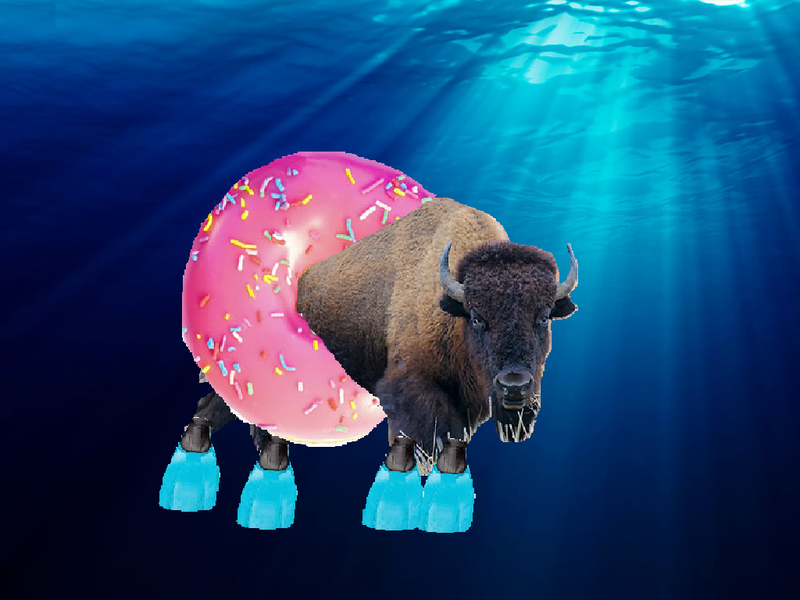

The Water Buffalo


In [10]:

# 👉 Edit this with the exact Animal name from the dataset (case-insensitive)
chosen_name = "Water Buffalo"
# find a picture of your animal and add it here
animal_pic = "https://images.uncyclomedia.co/uncyclopedia/en/thumb/3/3d/Water_buffalo.png/800px-Water_buffalo.png"
image = Image(animal_pic)
display(image)
print(f"The {chosen_name}")



In [11]:
#search for the animal in the dataset
mask = animals["Animal"].str.lower() == chosen_name.lower()
if mask.any():
    print(f"{chosen_name} found in dataset")
    display(animals[mask])
else:
    print(f"{chosen_name} not found in dataset")


Water Buffalo found in dataset


,Animal,Height (cm),Weight (kg),Color,Lifespan (years),Diet,Habitat,Predators,Average Speed (km/h),Countries Found,Conservation Status,Family,Gestation Period (days),Top Speed (km/h),Social Structure,Offspring per Birth
187,Water Buffalo,250.0,750.0,Dark Gray,22.5,Herbivore,"Grasslands, Wetlands","Tigers, Crocodiles",40.0,"Asia, Africa",Least Concern,Bovidae,255.0,40.0,Group-based,30-500


In [12]:
# this function is used to find a group of similar animals to the chosen animal
def get_similar_group(df, chosen_row):
    candidates = []
    if "Family" in df.columns and pd.notna(chosen_row.get("Family", np.nan)):
        fam = chosen_row["Family"]
        grp = df[df["Family"] == fam]
        if len(grp) >= 3:
            return grp, f"Family: {fam}"
        candidates.append(("Family", fam, len(grp)))
    if "Habitat" in df.columns and pd.notna(chosen_row.get("Habitat", np.nan)):
        hab = chosen_row["Habitat"]
        grp = df[df["Habitat"] == hab]
        if len(grp) >= 3:
            return grp, f"Habitat: {hab}"
        candidates.append(("Habitat", hab, len(grp)))
    if "Diet" in df.columns and pd.notna(chosen_row.get("Diet", np.nan)):
        diet = chosen_row["Diet"]
        grp = df[df["Diet"] == diet]
        if len(grp) >= 3:
            return grp, f"Diet: {diet}"
        candidates.append(("Diet", diet, len(grp)))
    return df, "All Animals (fallback)"


In [13]:

# Show the conservation status of all animals in the same family as the chosen animal
mask = animals["Animal"].str.lower() == chosen_name.lower()
if not mask.any():
    raise ValueError(f"Animal named '{chosen_name}' not found. Try another from animals['Animal'].unique()[:25]")

chosen = animals[mask].iloc[0]

if "Family" not in animals.columns or pd.isna(chosen.get("Family", None)):
    raise ValueError("Family information is not available for the chosen animal.")

family_name = chosen["Family"]
family_df = animals[animals["Family"] == family_name]

# Set group_df and group_desc to the family group, to preserve downstream code
group_df = family_df
group_desc = f"Family: {family_name} (n={len(group_df)})"

print(f"Conservation Status of animals in the Family: {family_name} (n={len(family_df)})")
display(family_df[["Animal", "Conservation Status"]])


Conservation Status of animals in the Family: Bovidae (n=10)


,Animal,Conservation Status
5,Alpine Ibex,Least Concern
7,American Bison,Near Threatened
10,Arabian Oryx,Vulnerable
70,Gaur,Vulnerable
71,Gerenuk,Near Threatened
116,Markhor,Near Threatened
145,Saola,Critically Endangered
187,Water Buffalo,Least Concern
194,Wildebeest,Least Concern
200,Yak,Least Concern



## 6) Compare Your Animal to Similar Species
We'll compare your chosen animal to others in the selected group for basic traits and risk.


In [ ]:

summary_stats = group_df.agg({
    c: ["mean","median"] for c in ["Height (cm)","Weight (kg)","Lifespan (years)"] if c in group_df.columns
})
summary_stats



In [ ]:

if "Conservation Status" in family_df.columns:
    family_df["Conservation Status"].value_counts().plot(kind="bar", figsize=(6,4))
    plt.title(f"Conservation Status in {group_desc}")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [ ]:

xcol, ycol = "Weight (kg)", "Lifespan (years)"
if xcol in group_df.columns and ycol in group_df.columns:
    status_codes = group_df["Conservation Status"].astype("category").cat.codes if "Conservation Status" in group_df.columns else np.zeros(len(group_df))
    plt.figure(figsize=(6,4))
    plt.scatter(group_df[xcol], group_df[ycol], c=status_codes, alpha=0.7)
    plt.scatter(chosen[xcol], chosen[ycol], s=160, edgecolor="black", linewidth=1.5, marker="*", label=chosen["Animal"])

    # Show names for each animal
    for _, row in group_df.iterrows():
        plt.text(row[xcol], row[ycol], str(row["Animal"]), fontsize=8, alpha=0.7)

    plt.title(f"{ycol} vs {xcol} in {group_desc}")
    plt.xlabel(xcol); plt.ylabel(ycol)
    plt.legend()
    plt.tight_layout()
    plt.show()




## 7) Your Turn: Ask a Question, Find Evidence
Pick **one** prompt (or create your own) and answer below:
- Does your animal have a **longer or shorter lifespan** than similar species? Might that affect its risk?
- Is your animal **heavier or lighter** than the group? How could that matter for survival?
- Which **Conservation Status** is most common in this group, and why might that be?

**Type your brief answer here (markdown):**



## 8  Try Another Comparison
Change `new_chosen_name` in the cell below to Try a different animal.


In [ ]:
# lets try a different animal
new_chosen_name = "cheetah" # place a new animal in the quotes here

# find a picture of your animal and add it here
new_animal_pic = "https://placehold.co/600x400.png"
new_image = Image(new_animal_pic)
display(new_image)
print(f"The {new_chosen_name}")


In [ ]:
#search for the animal in the dataset
mask = animals["Animal"].str.lower().str.contains(new_chosen_name.lower(), na=False)
matched = animals[mask]
if len(matched) == 0:
    print(f"{new_chosen_name} not found in dataset")
elif len(matched) == 1:
    print(f"{new_chosen_name} found in dataset")
    display(matched)
else:
    print(f"Multiple animals matched '{new_chosen_name}'. Please pick one by number:")
    display(matched.reset_index(drop=True)[["Animal"]])
    try:
        idx = int(input("Type the number next to your chosen animal (starting at 0): "))
        if 0 <= idx < len(matched):
            matched = matched.iloc[[idx]]
            print(f"You selected: {matched.iloc[0]['Animal']}")
            display(matched)
        else:
            print("Invalid choice. Please try running the cell again.")
            matched = matched.iloc[[0]]  # Fallback to first entry
    except Exception as e:
        print("Invalid input. Please try running the cell again.")
        matched = matched.iloc[[0]]  # Fallback to first entry

In [ ]:
# Show the conservation status of all animals in the same family as the new chosen animal

# We'll pick the first match for family analysis
chosen_new = matched.iloc[0]

# Include logic similar to the linked cell: check for "Family" column and handle missing/NA family
if "Family" not in animals.columns or pd.isna(chosen_new.get("Family", None)):
    raise ValueError("Family information is not available for the chosen animal.")

family_name_new = chosen_new["Family"]
family_group_df = animals[animals["Family"] == family_name_new]

# Also assign group_df and group_desc for possible downstream use (mirroring linked logic)
group_df = family_group_df
group_desc = f"Family: {family_name_new} (n={len(group_df)})"

print(f"Conservation Status of animals in the Family: {family_name_new} (n={len(family_group_df)})")
display(family_group_df[["Animal", "Conservation Status"]])


In [ ]:

# Compute summary statistics (mean, median) for all numeric columns in the group
numeric_cols = group_df.select_dtypes(include='number').columns
summary_stats = group_df[numeric_cols].agg(['mean', 'median'])
summary_stats


In [ ]:
if "Conservation Status" in group_df.columns:
    status_counts = group_df["Conservation Status"].value_counts()
    ax = status_counts.plot(kind="bar", figsize=(6, 4), color="teal", edgecolor="black")
    ax.set_title(f"Conservation Status in {group_desc}")
    ax.set_xlabel("Conservation Status")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

In [ ]:
xcol, ycol = "Gestation Period (days)", "Lifespan (years)" # changed the x and y columns to compare different traits
if xcol in group_df.columns and ycol in group_df.columns:
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    statuses = group_df["Conservation Status"].astype(str).fillna("Unknown")
    categories = statuses.astype("category").cat.categories
    n_status = len(categories)


    cmap = cm.get_cmap("tab10" if n_status <= 10 else "tab20", n_status)
    color_map = {cat: cmap(i) for i, cat in enumerate(categories)}
    colors = statuses.map(color_map)

    plt.figure(figsize=(6,4))
    plt.scatter(group_df[xcol], group_df[ycol], c=colors, alpha=0.7, label=None)

    plt.scatter(
        chosen_new[xcol], chosen_new[ycol],
        s=160, edgecolor="black", linewidth=1.5,
        marker="*", label=chosen_new["Animal"],
        color=color_map.get(str(chosen_new.get("Conservation Status", "Unknown")), "gold")
    )

    for _, row in group_df.iterrows():
        plt.text(row[xcol], row[ycol], str(row["Animal"]), fontsize=8, alpha=0.7)

    plt.title(f"{ycol} vs {xcol} in {group_desc}")
    plt.xlabel(xcol)
    plt.ylabel(ycol)

    import matplotlib.patches as mpatches
    handles = [mpatches.Patch(color=color_map[cat], label=cat) for cat in categories]

    handles.append(
        plt.Line2D(
            [0], [0], marker='*', color='w', label=chosen_new["Animal"],
            markerfacecolor=color_map.get(str(chosen_new.get("Conservation Status", "Unknown")), "gold"),
            markeredgecolor='black', markersize=15, linewidth=0
        )
    )
    plt.legend(handles=handles, title="Conservation Status / Animal", loc='best', fontsize=8)

    plt.tight_layout()
    plt.show()



## 9) Reflection (Exit Ticket)
- What **surprised** you in the data today?
- How did **cleaning** the data change what you could learn?
- If you were designing a **conservation project**, which animals would you focus on—and why?

---

_Last updated: 2025-10-21 20:05 UTC_


# place your thoughts here

-